# Training a Deep Learning Model with Transfer Learning Using Pretrained `EfficientNetB0` model

> Utilizing a Pretrained Model for Image Classification
> 
The objective of this notebook is to develop a deep learning model for image classification, leveraging transfer learning with the EfficientNetB0 architecture.

### Importing TensorFlow

In [7]:
import tensorflow as tf

### Getting train data and validation data and turn them into batches, shuffling, formatting etc...

In [8]:
train_dir = 'dataset/Dataset/train'
val_dir = 'dataset/Dataset/val'

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                shuffle=True, ## shuffling while reading the images 
                                                                batch_size=32, ## default is 32, we can ignore
                                                                label_mode='categorical',  ##specifying format of the labels
                                                                image_size=(336, 336)) ## Setting ['width', 'height']

validation_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                      label_mode='categorical',
                                                                      batch_size=32, 
                                                                      image_size=(336, 336))

Found 3996 files belonging to 20 classes.
Found 1250 files belonging to 20 classes.


### Getting Class names

In [9]:
import pathlib
import os
path = pathlib.Path(train_dir)
class_names = sorted(os.listdir(path))
len(class_names), class_names

(20,
 ['burger',
  'butter_naan',
  'chai',
  'chapati',
  'chole_bhature',
  'dal_makhani',
  'dhokla',
  'fried_rice',
  'idli',
  'jalebi',
  'kaathi_rolls',
  'kadai_paneer',
  'kulfi',
  'masala_dosa',
  'momos',
  'paani_puri',
  'pakode',
  'pav_bhaji',
  'pizza',
  'samosa'])

### Ploting Random Images

In [10]:
train_sample_image = train_data.take(1)
vali_sample_image = validation_data.take(1)

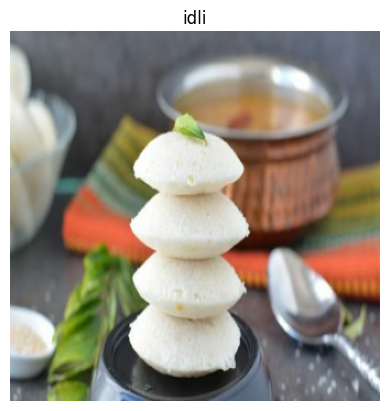

In [11]:
import matplotlib.pyplot as plt
import random
for image, label in vali_sample_image:
    rand_index = random.randint(0, 30)
    image = image[rand_index]/255.
    label = tf.argmax(label[rand_index]).numpy()
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis(False)

### Creating Sequential() model to Augment the data

In [12]:
import tensorflow.keras.layers as layers
data_augmentation = tf.keras.models.Sequential([
    layers.RandomFlip('verticle'),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

### Building the Main `EfficientNetB0` model using tf.keras.applications.EfficientNetB0()
How ever, we are not training the `EfficientNetB0` model, we are just using pretrained model with saved weight

In [13]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False) ## Main model

base_model.trainable = False ## freeze training the model

inputs = tf.keras.layers.Input(shape=(336, 336, 3), name='input_layer') ## Adding input layer

x = data_augmentation(inputs) ## Adding Augmenting layer by passing the input layer for augmentation

x = base_model(x, training=False) ## Passing the augmentation layer to the base model (EfficientNetB0)

x = tf.keras.layers.GlobalAveragePooling2D(name='globa_average_pooing')(x) ## Adding a Pooling layer

output = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x) ## adding output layer

model = tf.keras.Model(inputs, output) ## Creating a model

## Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
## Getting the summary of the model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 336, 336, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ globa_average_pooing                 │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 20)                  │          25,620 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,075,191 (15.55 MB)

 Trainable params: 25,620 (100.08 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Fitting the model with training data and adding validation data to validate while training (not on full validation data)

In [15]:
history = model.fit(train_data,
                    epochs=5, ## Training for 5 epochs
                    validation_data=validation_data,
                    validation_steps=int(0.15 * len(validation_data))) ## only 15% of the validation data

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4837 - loss: 2.0703 - val_accuracy: 0.8490 - val_loss: 0.7391
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.8652 - loss: 0.6815 - val_accuracy: 0.9323 - val_loss: 0.4074
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9088 - loss: 0.4543 - val_accuracy: 0.9062 - val_loss: 0.3810
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9173 - loss: 0.3612 - val_accuracy: 0.9375 - val_loss: 0.2948
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9329 - loss: 0.3057 - val_accuracy: 0.9375 - val_loss: 0.2923


### Evaluating the model with validation data

In [16]:
eval_model = model.evaluate(validation_data)
eval_model

40/40 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9148 - loss: 0.3194


[0.3024503290653229, 0.9287999868392944]

### Plotting the accuracy_curve and loss_curves

<Axes: >

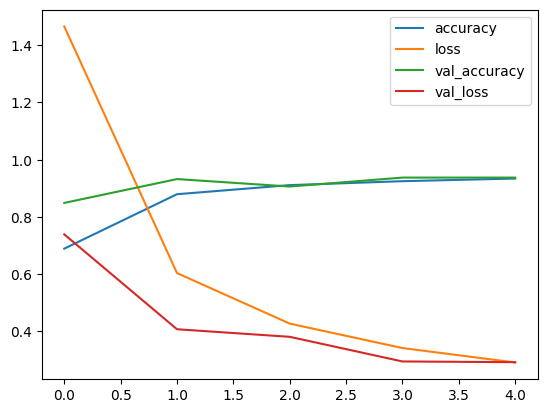

In [17]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [18]:
test_dir = 'test'
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(336, 336),
                                                                label_mode='categorical')

Found 585 files belonging to 20 classes.


In [19]:
585/20

29.25

### Making prediction on test data

In [20]:
y_preds_probs = model.predict(test_data)

19/19 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


In [21]:
y_preds_probs = [tf.argmax(item).numpy() for item in y_preds_probs]
y_preds_probs[:6]

[13, 4, 1, 15, 16, 14]

### Saving and loading model

In [22]:
model.save('food_classifier_model.keras')

In [23]:
loaded_model = tf.keras.models.load_model('food_classifier_model.keras')

In [24]:
loaded_model.evaluate(validation_data)

40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9003 - loss: 0.3570


[0.349852591753006, 0.897599995136261]

### Function to predict and plot on loaded data (train, validation, test)

In [25]:
import matplotlib.image as mimg
def pred_plot(directory):
    filename = os.listdir(directory)
    rand_file = random.choice(filename)
    rand_index = random.randint(0, 25) 
    file_path = os.path.join(directory, rand_file)
    image_file = os.listdir(file_path)[rand_index]
    rand_image_path = os.path.join(file_path, image_file)
    image = mimg.imread(rand_image_path)
    plt.imshow(image)

    image = tf.image.resize(image, [336, 336])
    image = tf.expand_dims(image, axis=0)
    
    pred = model.predict(image).argmax()
    if class_names[pred] == rand_file:
        color='g'
    else:
        color='r'
    plt.title(f"Predicted: {class_names[pred]}, Actual: {rand_file}", color=color)
    plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


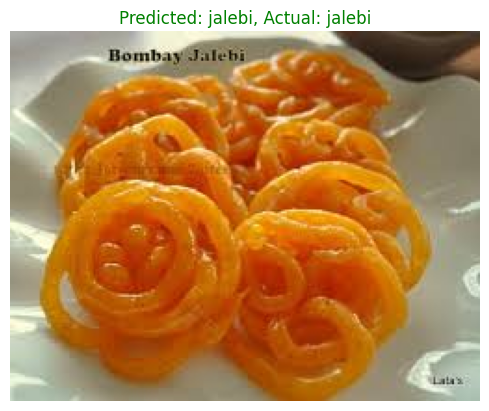

In [47]:
pred_plot('test')

### Function to read an image and predict

In [27]:
def prep_pred_plot(imagefile):
    img = mimg.imread(imagefile)
    plt.imshow(img)
    img = tf.image.resize(img, [336, 336])
    img = tf.expand_dims(img, axis=0)

    own_pred = model.predict(img).argmax()
    plt.title(f'Predicted: {class_names[own_pred]}')
    plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


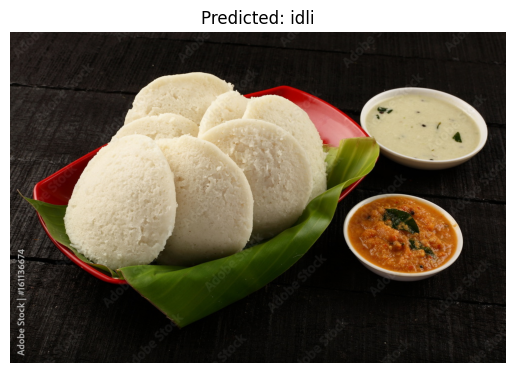

In [28]:
prep_pred_plot('idli.jpg')